### Подключение библиотек

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re 
import seaborn as sns
import pickle as pkl

import json
from sklearn.feature_selection import RFE
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR
from sklearn.decomposition import *
from pprint import pprint
from sklearn.preprocessing import *
from sklearn.neighbors import *
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.metrics import *
from sklearn.tree import *

### Обучение и выполнение лучшей модели

In [5]:
# Путь к тренировочному набору
path_train =  "train.csv"
# Путь к тестовому набору
path_test  =  "test.csv"

In [6]:
data = pd.read_csv(path_train)

In [7]:
data['Mileage'] = data.Mileage.str.extract('(\d+)').astype(int)
data['is_turbo'] = np.where(data['Engine_volume'].str.contains('Turbo'), 1, 0)
data['Engine_volume'] = data.Engine_volume.str.extract('(\d+)').astype(float)
data['Leather_interior'] = data['Leather_interior'].replace({'No':0,'Yes':1})

In [8]:
categorical_features = ['Brand', 'Model', 'Year_of_production', 'Type',
                        'Leather_interior', 'Fuel_type',
                        'Cylinders', 'Gear_box', 'Drive_wheels', 'Doors', 'Color', 'Airbags']


In [9]:
X = data.drop(["Price", "ID"], axis=1)
Y = data["Price"]

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, shuffle = True, random_state = 42)

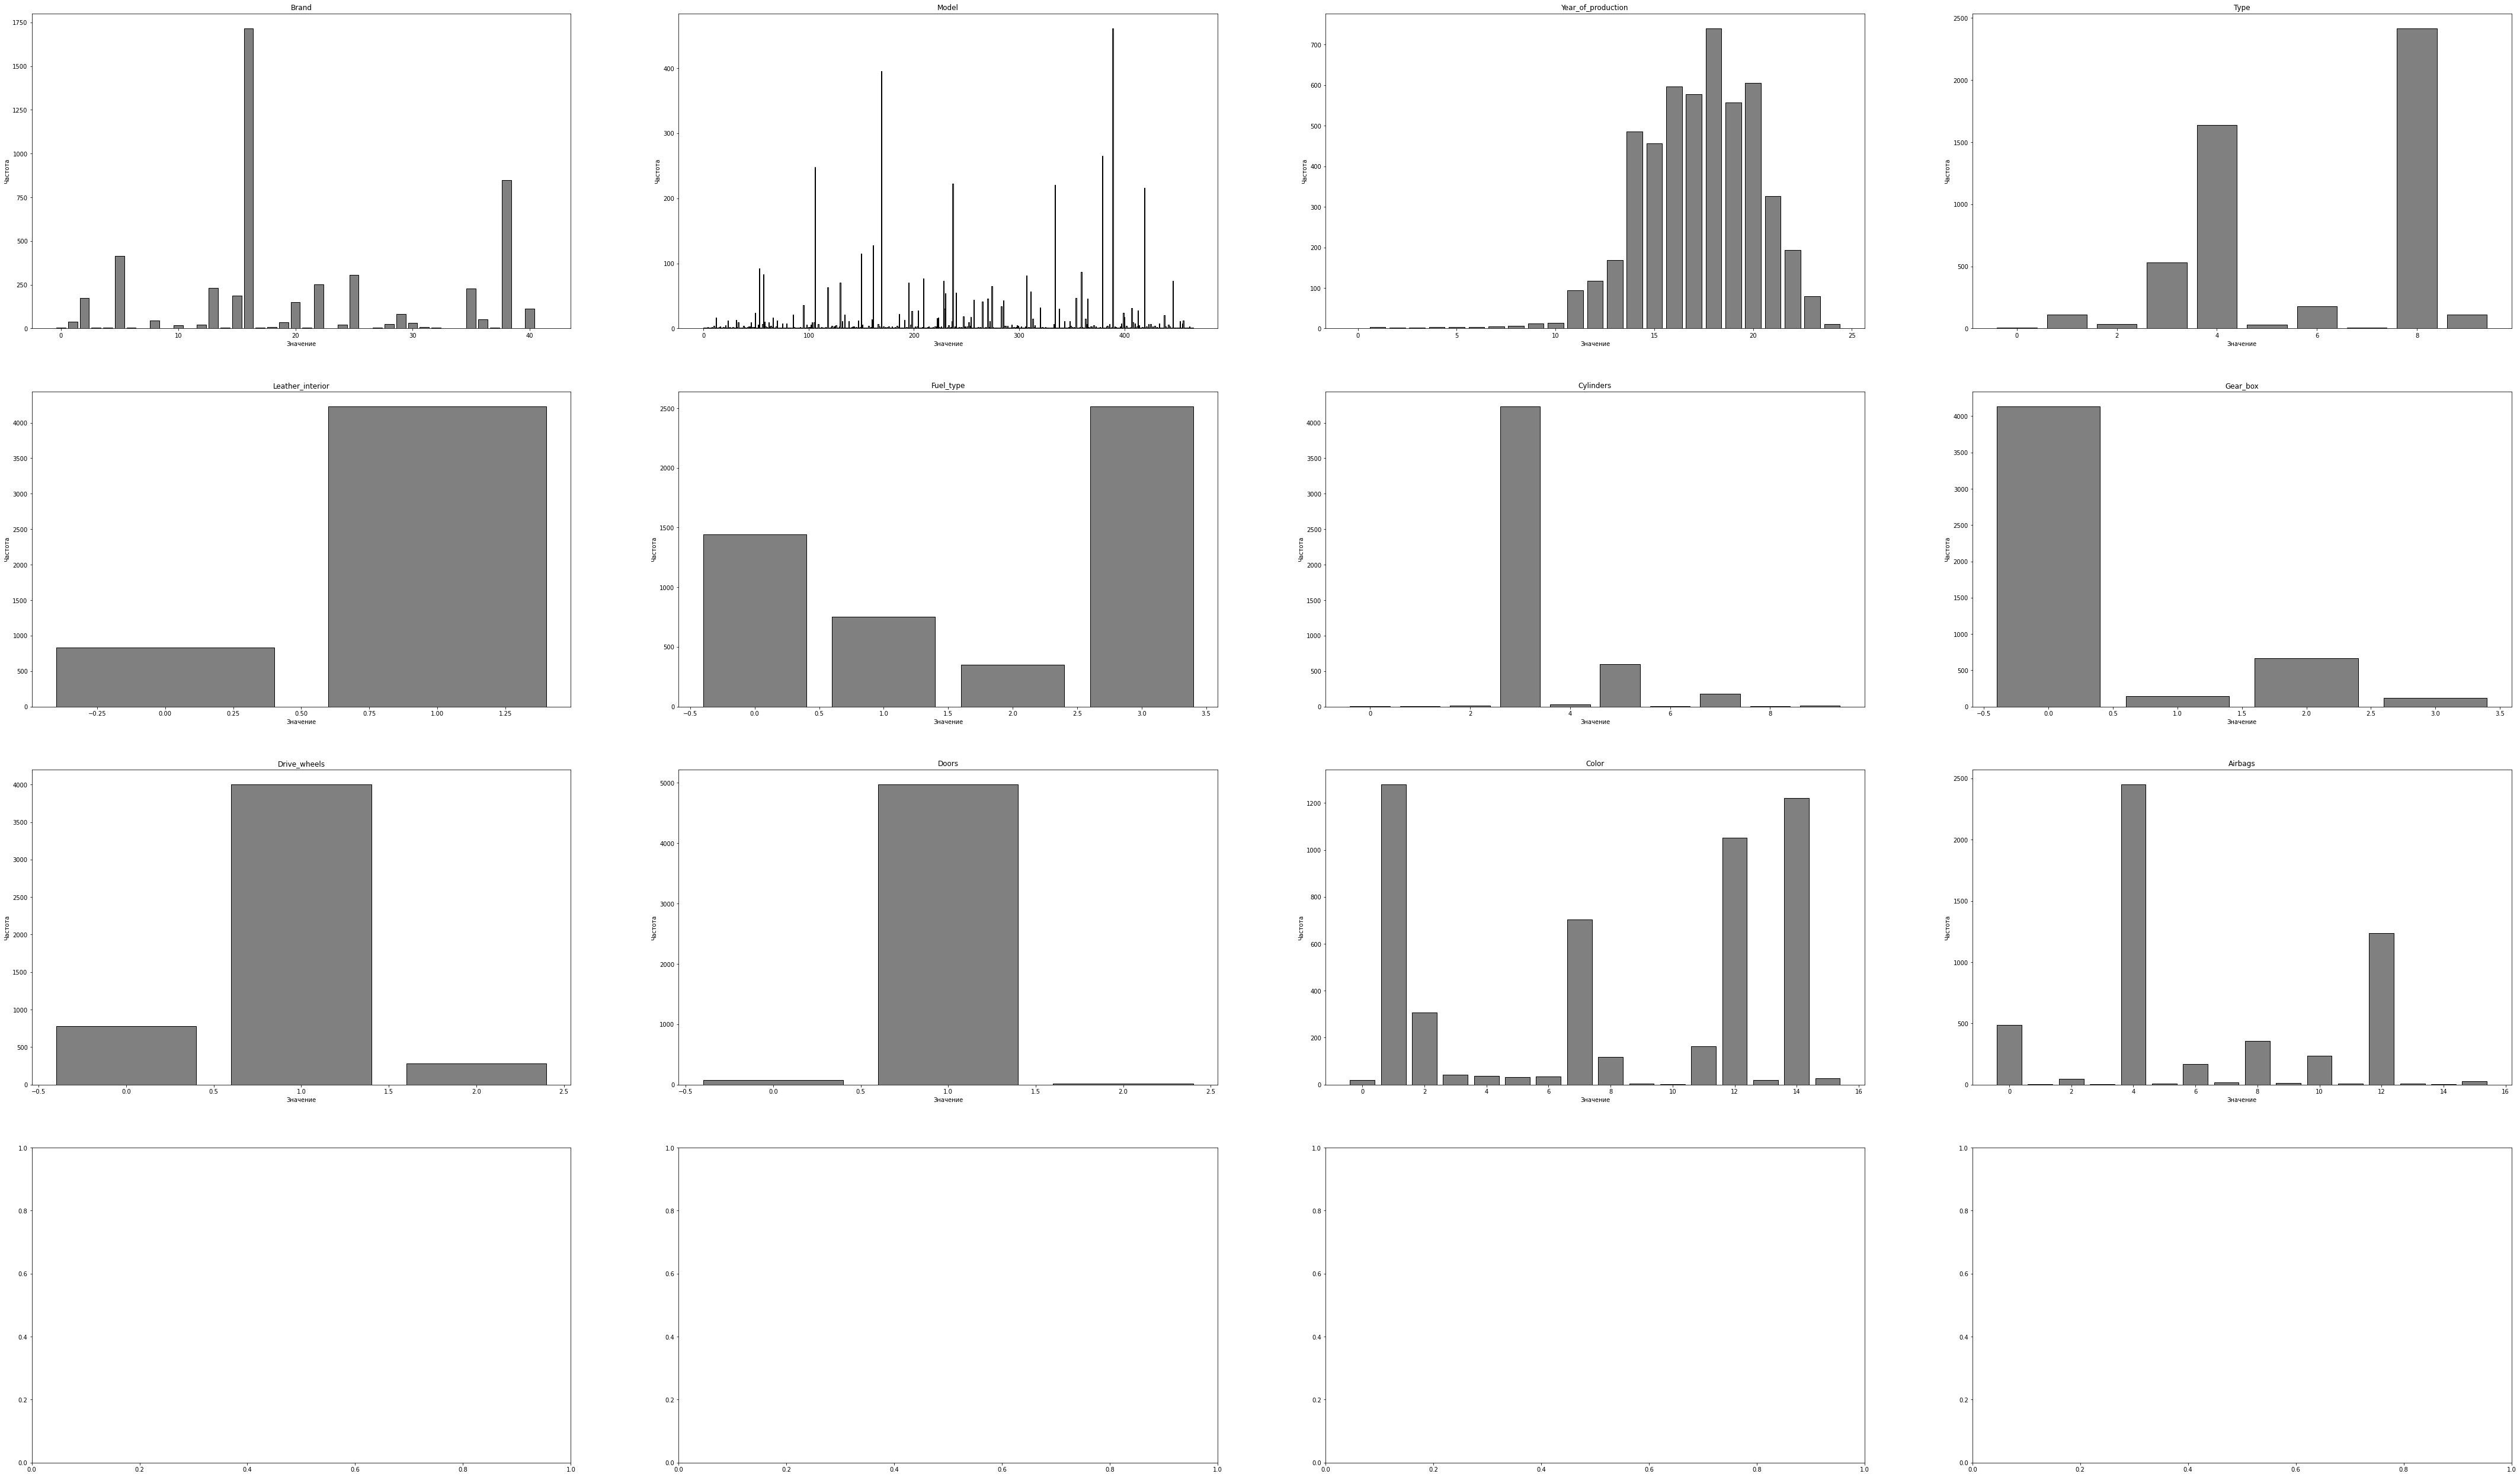

In [11]:
fig, axs = plt.subplots(nrows= 4 , ncols= 4 )

fig.set_figheight(45)
fig.set_figwidth(75)

le = LabelEncoder()

for i in range(len(categorical_features)):
    current_feature = categorical_features[i]
    le.fit(x_train[current_feature])
    bins = np.bincount(le.transform(x_train[current_feature]))
    
    axs[i // 4, i % 4].set_title(current_feature)
    axs[i // 4, i % 4].bar(range(len(bins)), bins, color='gray', edgecolor='black')
    axs[i // 4, i % 4].set_ylabel("Частота")
    axs[i // 4, i % 4].set_xlabel("Значение")

In [12]:
scale_features = ["Mileage", "Tax", "Engine_volume"]
scaler = RobustScaler()

x_train[scale_features] = scaler.fit_transform(x_train[scale_features])

In [13]:
x_train.reset_index(drop=True, inplace=True)
x_test.reset_index (drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index (drop=True, inplace=True)

In [14]:
def create_target_feature_encoding(X, Y, features):
  features_values_targets = {}
  
  for feature in features:
    features_values_targets[feature] = {}
    for value in set(X[feature]):
      features_values_targets[feature][value] = np.mean(Y[X[feature] == value])

  return features_values_targets

In [15]:
x_train = x_train.fillna(-1)

onehot = OneHotEncoder(handle_unknown = 'ignore')
onehot.fit(data[categorical_features])

x_train = pd.concat([pd.DataFrame(onehot.transform(x_train[categorical_features]).toarray()), x_train], axis=1)
x_test = pd.concat([pd.DataFrame(onehot.transform(x_test[categorical_features]).toarray()), x_test], axis=1)


In [16]:
target_features = ["Brand", "Cylinders", "Engine_volume"]
features_values_targets = create_target_feature_encoding(x_train, y_train, target_features)
  
for feature in target_features:
  x_train[feature] = x_train[feature].replace(features_values_targets[feature])
  x_test[feature]  = x_test [feature].replace(features_values_targets[feature])

In [17]:
x_train = x_train.drop(set(categorical_features) - set(target_features), axis = 1)
x_test  = x_test.drop(set(categorical_features) - set(target_features),  axis = 1)

In [18]:
for feature in target_features:
  x_test[feature] = x_test[feature].apply(lambda value: value if type(value) == np.float64 else 0)

x_test[scale_features] = scaler.transform(x_test[scale_features])

In [19]:
def print_metrics(targets, preds):
  print("MAE : ", mean_absolute_error(targets, preds))
  print("MSE : ", mean_squared_error(targets, preds))
  print("R2 : ", r2_score(targets, preds))
  print("MAPE : ", mean_absolute_percentage_error(targets, preds))

In [20]:
x_train = x_train.values
x_test  = x_test.values 

In [21]:
cv = KFold(n_splits=2, random_state=0, shuffle = True)

In [22]:
forest = RandomForestRegressor(random_state=42)

parameters_grid = {
     'max_depth'        : [25, 26, 27],
     'n_estimators'     : [100, 200]
     }


grid_cv_forest = GridSearchCV(forest, parameters_grid, scoring='neg_mean_absolute_error', cv = cv)
grid_cv_forest.fit(x_train, y_train)

forest_preds = grid_cv_forest.predict(x_test)
print_metrics(y_test, forest_preds)

MAE :  4827.6279822261995
MSE :  65953599.6277203
R2 :  0.7064994031490448
MAPE :  0.31346135698419464


In [23]:
grid_cv_forest.best_params_

{'max_depth': 27, 'n_estimators': 200}

# Test

In [24]:
model = RandomForestRegressor(n_estimators = 200, max_depth = 27)

model.fit(np.concatenate([x_train, x_test]), np.concatenate([y_train, y_test]))

RandomForestRegressor(max_depth=27, n_estimators=200)

In [25]:
test_data = pd.read_csv(path_test)

In [26]:
test_data['Mileage'] = test_data.Mileage.str.extract('(\d+)').astype(int)
test_data['is_turbo'] = np.where(test_data['Engine_volume'].str.contains('Turbo'), 1, 0)
test_data['Engine_volume'] = test_data.Engine_volume.str.extract('(\d+)').astype(float)
test_data['Leather_interior'] = test_data['Leather_interior'].replace({'No':0,'Yes':1})

test_data = test_data.drop(["ID"], axis=1)

In [27]:
test_data = pd.concat([pd.DataFrame(onehot.transform(test_data[categorical_features]).toarray()), test_data], axis=1)

In [28]:
for feature in target_features:
  test_data[feature]  = test_data[feature].replace(features_values_targets[feature])

test_data = test_data.drop(set(categorical_features) - set(target_features), axis = 1)

In [29]:
for feature in target_features:
  test_data[feature] = test_data[feature].apply(lambda value: value if type(value) == np.float64 else 0)

test_data[scale_features] = scaler.transform(test_data[scale_features])

In [30]:
# Маска отобраных номеров строк для предсказания из тестового набора
mask = test_data.index

# Название вектора предсказанных значений  y_predict полученого на основании тестового набора
y_predict = model.predict(test_data.loc[mask].values)